# Liesel-GAM Demo Notebook

## Setup and Imports

In [1]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import numpy as np
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [2]:
# import data from R
from ryp import r, to_py

r("library(mgcv)")
r("data(columb)")
r("data(columb.polys)")

columb = to_py("columb", format="pandas").reset_index()
polys = to_py("columb.polys", format="numpy")

Loading required package: nlme
This is mgcv 1.9-3. For overview type 'help("mgcv-package")'.


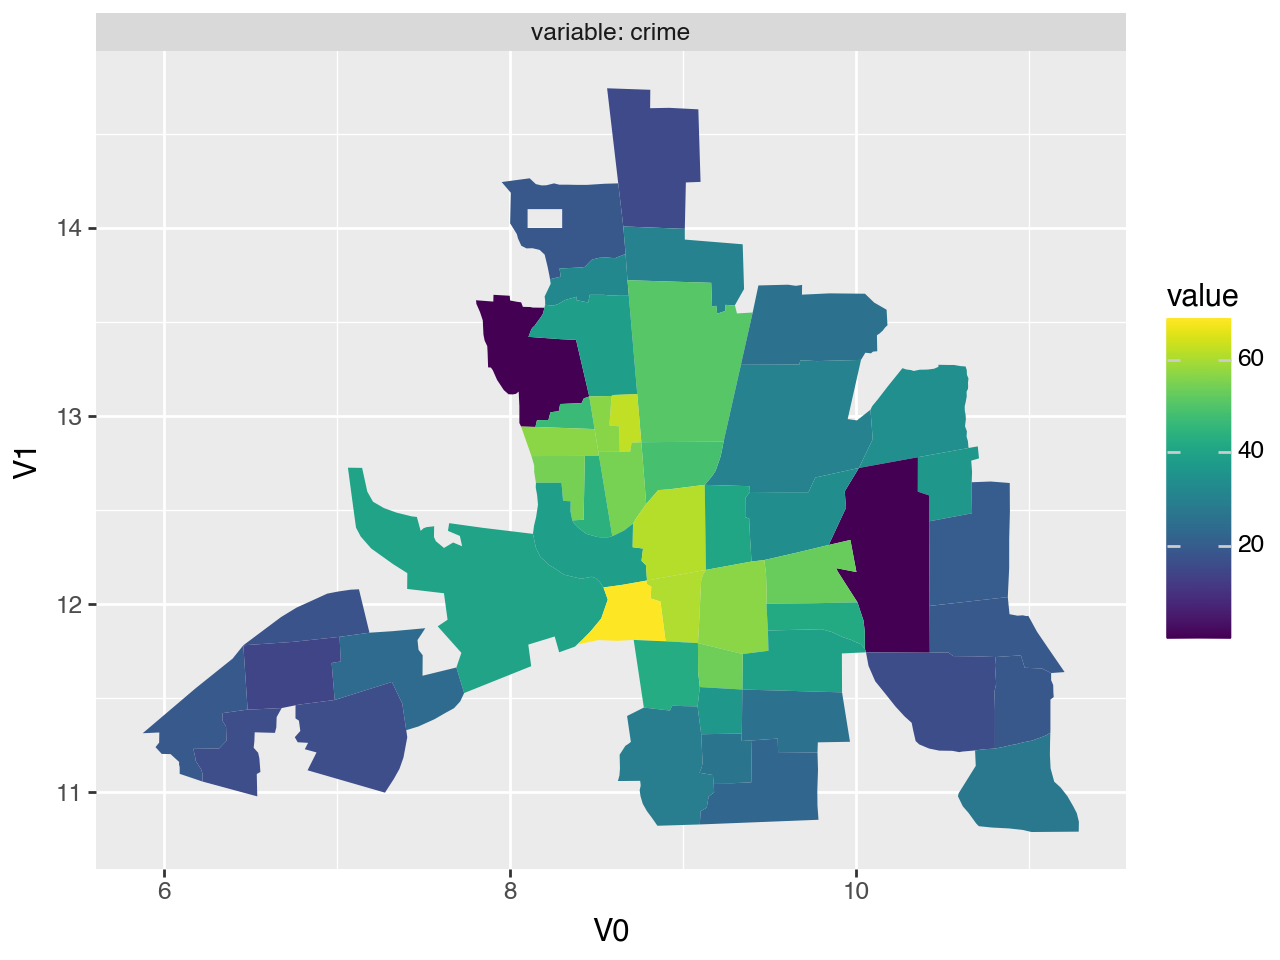

In [3]:
gam.plot_polys(region="district", plot_vars=["crime"], df=columb, polys=polys)

## Model Definition

### Setup response model

In [4]:
i = np.arange(columb.shape[0])
i10 = i[:10]
i20 = i[11:20]
i30 = i[21:30]
irest = i[31:]
i = np.concatenate((i10, i20, i30, irest))
df = columb.iloc[i, :].reset_index()

In [5]:
loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.crime.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

tb = gam.TermBuilder.from_df(df)
loc += tb.mrf(
    "district",
    polys=polys,
    absorb_cons=True,
    diagonal_penalty=True,
    scale_penalty=True,
    noncentered=True,
)

### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="y_value").value


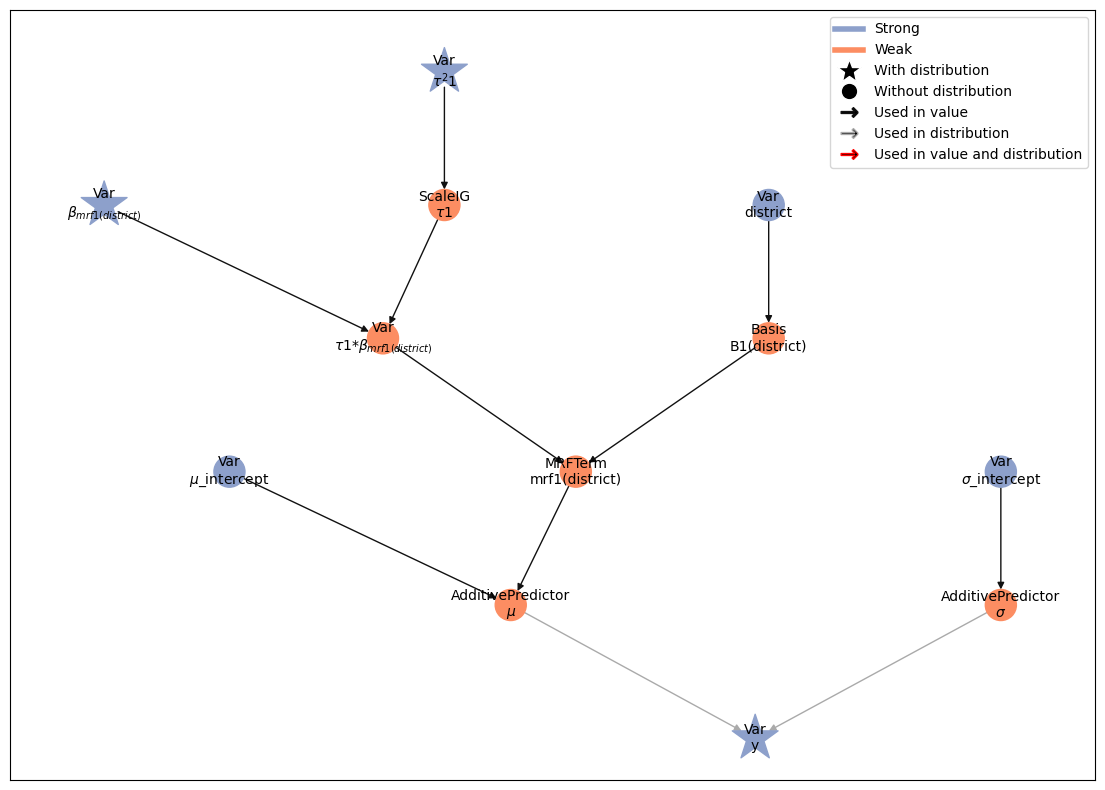

In [6]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

In [7]:
eb = gs.LieselMCMC(model).get_engine_builder(seed=1, num_chains=4)

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=10000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\sigma$_intercept', '$\\mu$_intercept', '$\\beta_{mrf1(district)}$', '$\\tau^2$1'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:02<00:00,  6.05chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|████████████████████████████████████████| 1/1 [00:00<00:00, 1618.17chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|████████████████████████████████████████| 2/2 [00:00<00:00, 1834.78chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 1, 0, 0,

### MCMC summary

In [8]:
summary = gs.Summary(results)
summary

Parameter summary:

                                   kernel       mean         sd     q_0.05  \
parameter                index                                               
$\beta_{mrf1(district)}$ (0,)   kernel_02   0.128106   1.023759  -1.591231   
                         (1,)   kernel_02   0.006526   0.996284  -1.622611   
                         (2,)   kernel_02   0.119360   0.994299  -1.511603   
                         (3,)   kernel_02   0.185263   1.012334  -1.496412   
                         (4,)   kernel_02   0.029113   0.966330  -1.572622   
                         (5,)   kernel_02  -0.022528   0.970871  -1.612303   
                         (6,)   kernel_02  -0.005990   1.005380  -1.668066   
                         (7,)   kernel_02  -0.007992   0.946845  -1.535992   
                         (8,)   kernel_02   0.033642   0.978629  -1.587302   
                         (9,)   kernel_02  -0.165955   1.031347  -1.857402   
                         (10,)  kernel_02   0.101870   0.986827  -1.513703   
                         (11,)  kernel_02  -0.099761   0.988057  -1.747616   
                         (12,)  kernel_02   0.042211   0.963000  -1.550544   
                         (13,)  kernel_02  -0.062927   0.954273  -1.607219   
                         (14,)  kernel_02  -0.007068   0.965662  -1.594749   
                         (15,)  kernel_02  -0.191801   1.048527  -1.927048   
                         (16,)  kernel_02   0.065031   0.990302  -1.553252   
                         (17,)  kernel_02  -0.007875   0.969231  -1.616684   
                         (18,)  kernel_02   0.057957   0.989991  -1.552124   
                         (19,)  kernel_02   0.100666   0.994526  -1.594123   
                         (20,)  kernel_02  -0.078397   0.962835  -1.651596   
                         (21,)  kernel_02  -0.313953   1.059191  -2.052733   
                         (22,)  kernel_02  -0.050689   0.957333  -1.611594   
                         (23,)  kernel_02   0.023123   0.978923  -1.583835   
                         (24,)  kernel_02   0.093381   0.997715  -1.533364   
                         (25,)  kernel_02   0.071318   0.961614  -1.550165   
                         (26,)  kernel_02   0.053974   0.998694  -1.564082   
                         (27,)  kernel_02  -0.077255   0.971237  -1.674314   
                         (28,)  kernel_02  -0.125637   0.982129  -1.685992   
                         (29,)  kernel_02   0.094754   0.974416  -1.541114   
                         (30,)  kernel_02  -0.112307   0.965952  -1.693742   
                         (31,)  kernel_02   0.014375   0.969780  -1.584142   
                         (32,)  kernel_02   0.152040   0.991744  -1.473157   
                         (33,)  kernel_02   0.124439   0.996356  -1.536011   
                         (34,)  kernel_02  -0.087928   0.963438  -1.659507   
                         (35,)  kernel_02   0.123249   0.953111  -1.466655   
                         (36,)  kernel_02  -0.206750   0.955685  -1.741759   
                         (37,)  kernel_02  -0.034212   0.985877  -1.659009   
                         (38,)  kernel_02  -0.026049   0.964366  -1.616128   
                         (39,)  kernel_02   0.179057   0.975278  -1.451574   
                         (40,)  kernel_02   0.266517   1.030897  -1.501810   
                         (41,)  kernel_02   0.232931   0.984199  -1.450917   
                         (42,)  kernel_02  -0.366518   1.047141  -2.000383   
                         (43,)  kernel_02  -0.205611   0.950641  -1.703051   
                         (44,)  kernel_02   0.499989   1.072357  -1.310305   
                         (45,)  kernel_02  -0.569911   1.085146  -2.193366   
                         (46,)  kernel_02   0.168619   0.915901  -1.439959   
                         (47,)  kernel_02   0.467160   0.916284  -1.203427   
$\mu$_intercept          ()     kernel_01  34.770741   2.360556  30.871763   
$\

## Plots

In [9]:
samples = results.get_posterior_samples()

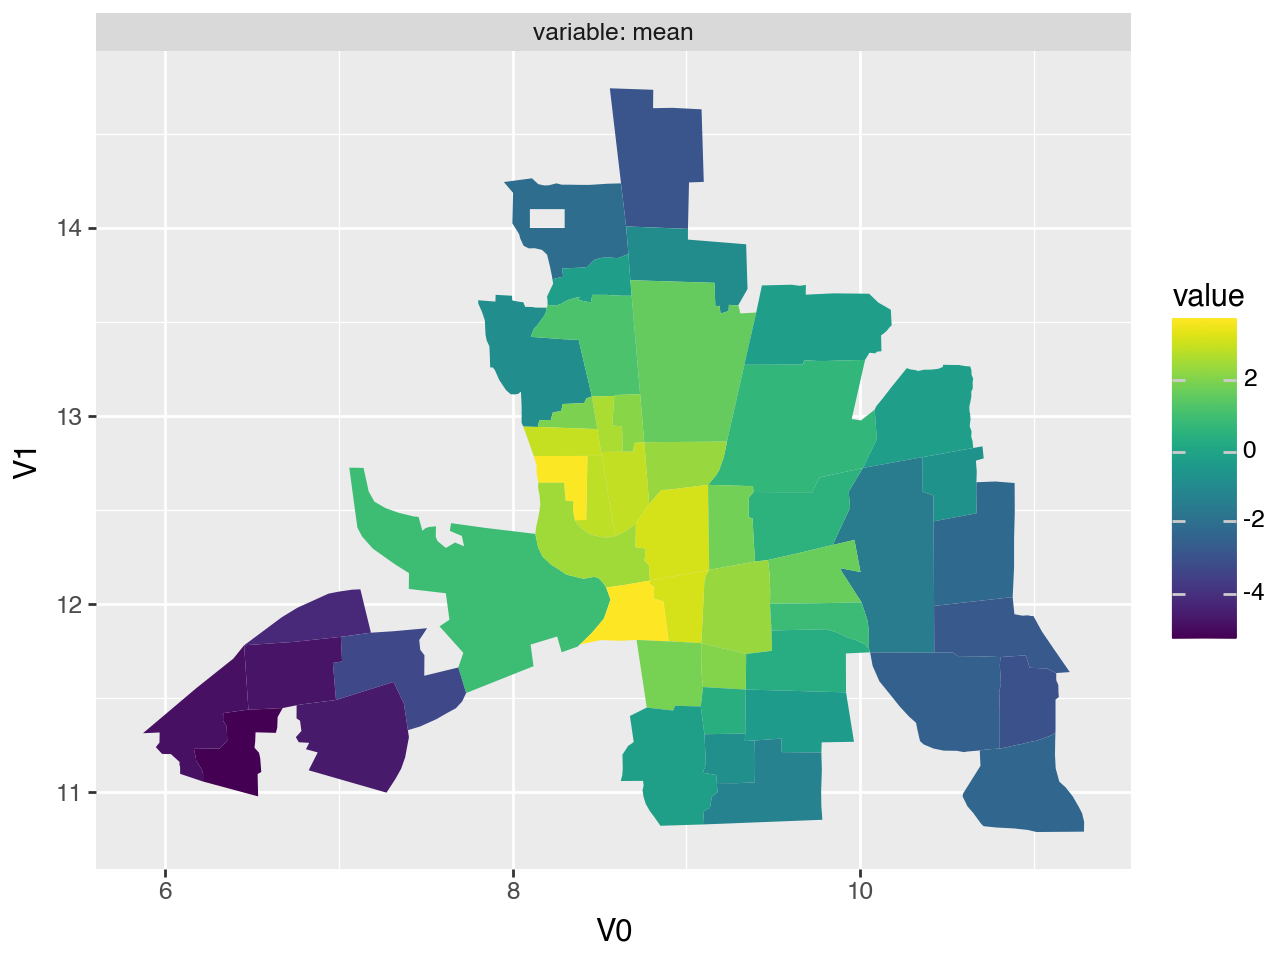

In [10]:
gam.plot_regions(term=loc.terms["mrf1(district)"], samples=samples, polys=polys)

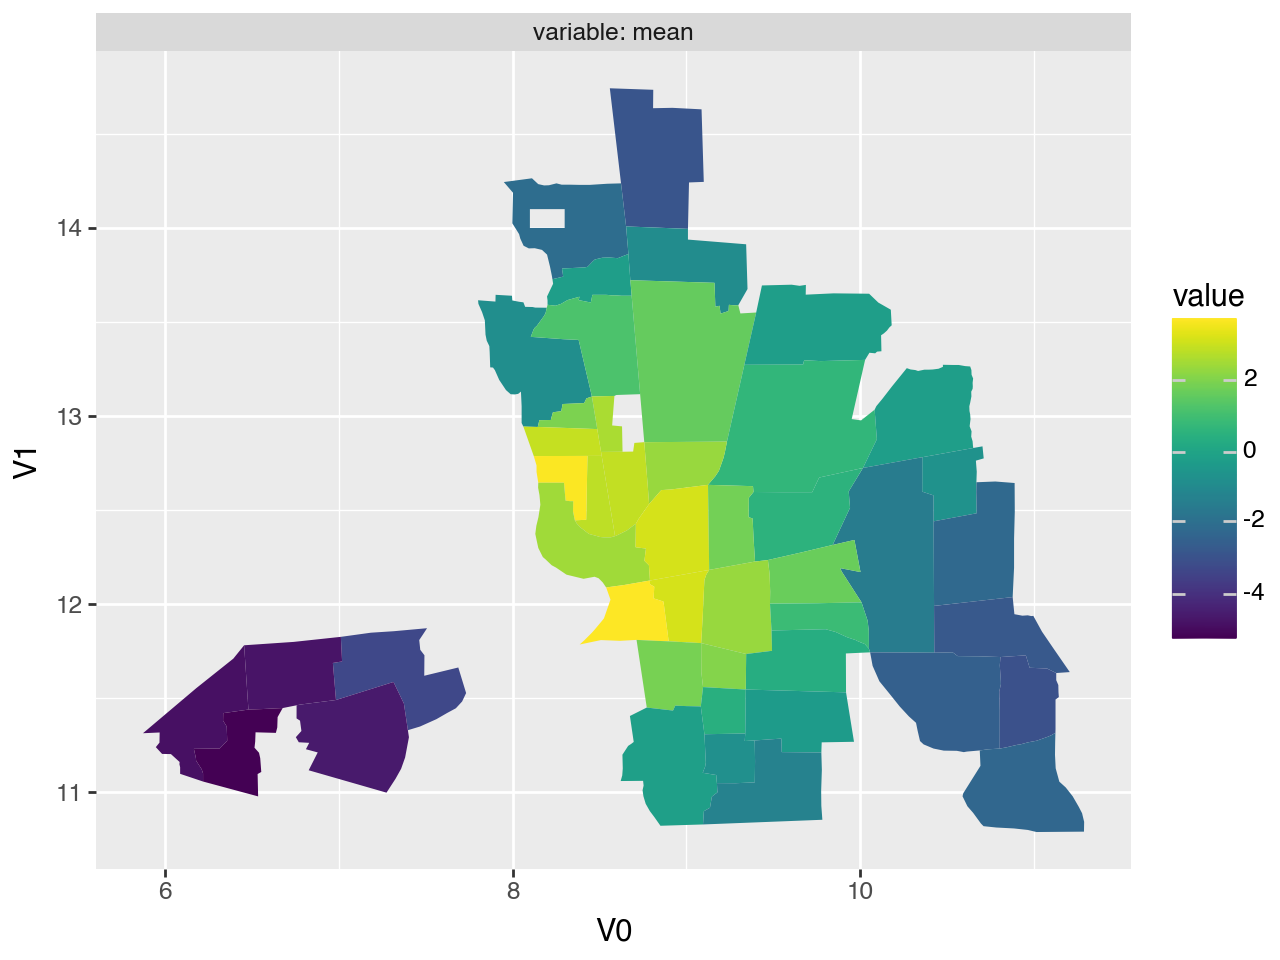

In [ ]:
gam.plot_regions(
    term=loc.terms["mrf1(district)"],
    samples=samples,
    polys=polys,
    show_unobserved=False,
)

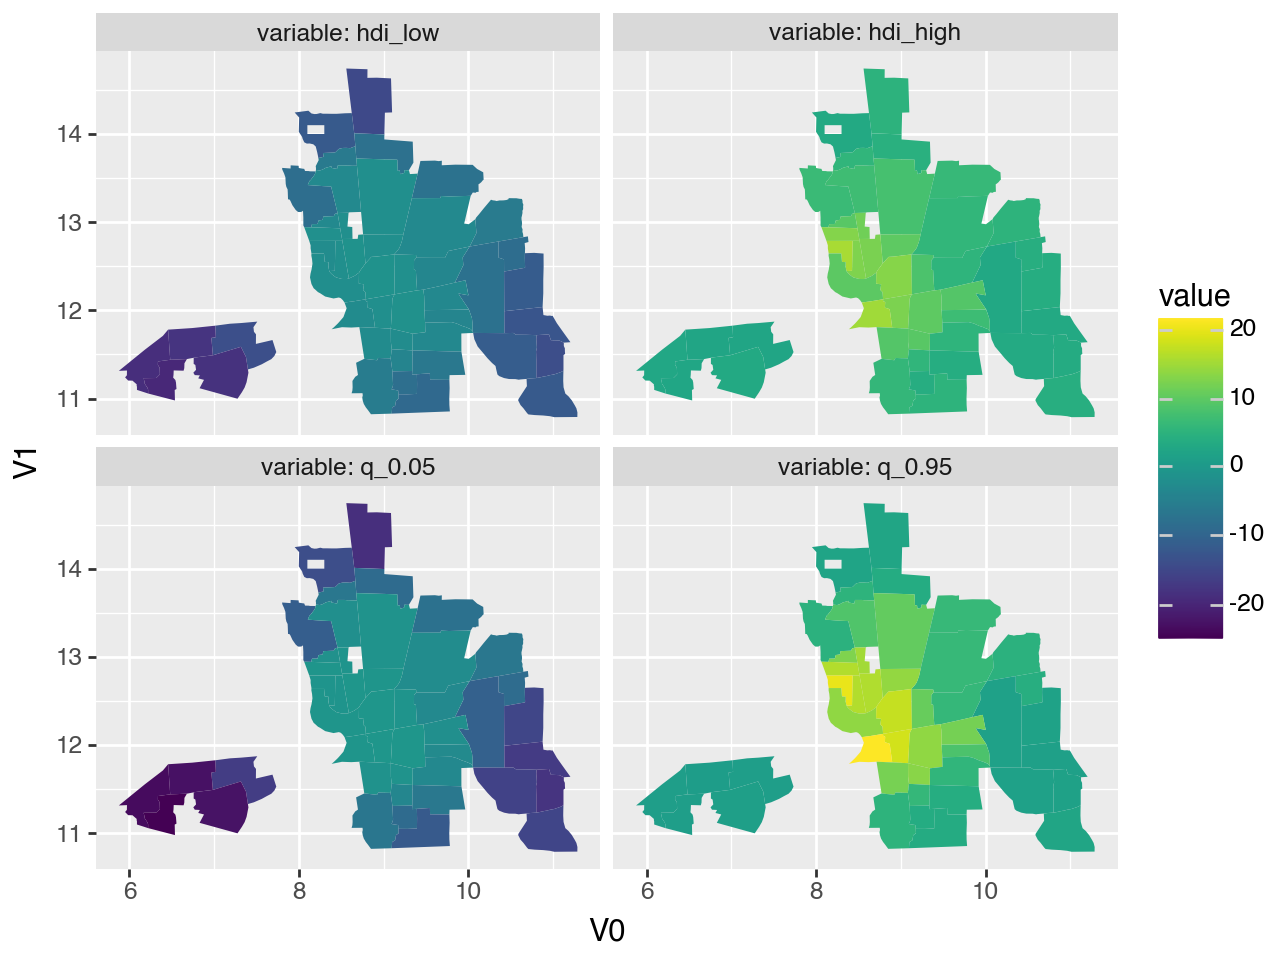

In [ ]:
gam.plot_regions(
    term=loc.terms["mrf1(district)"],
    samples=samples,
    polys=polys,
    plot_vars=["hdi_low", "hdi_high", "q_0.05", "q_0.95"],
    # show_unobserved=False
)

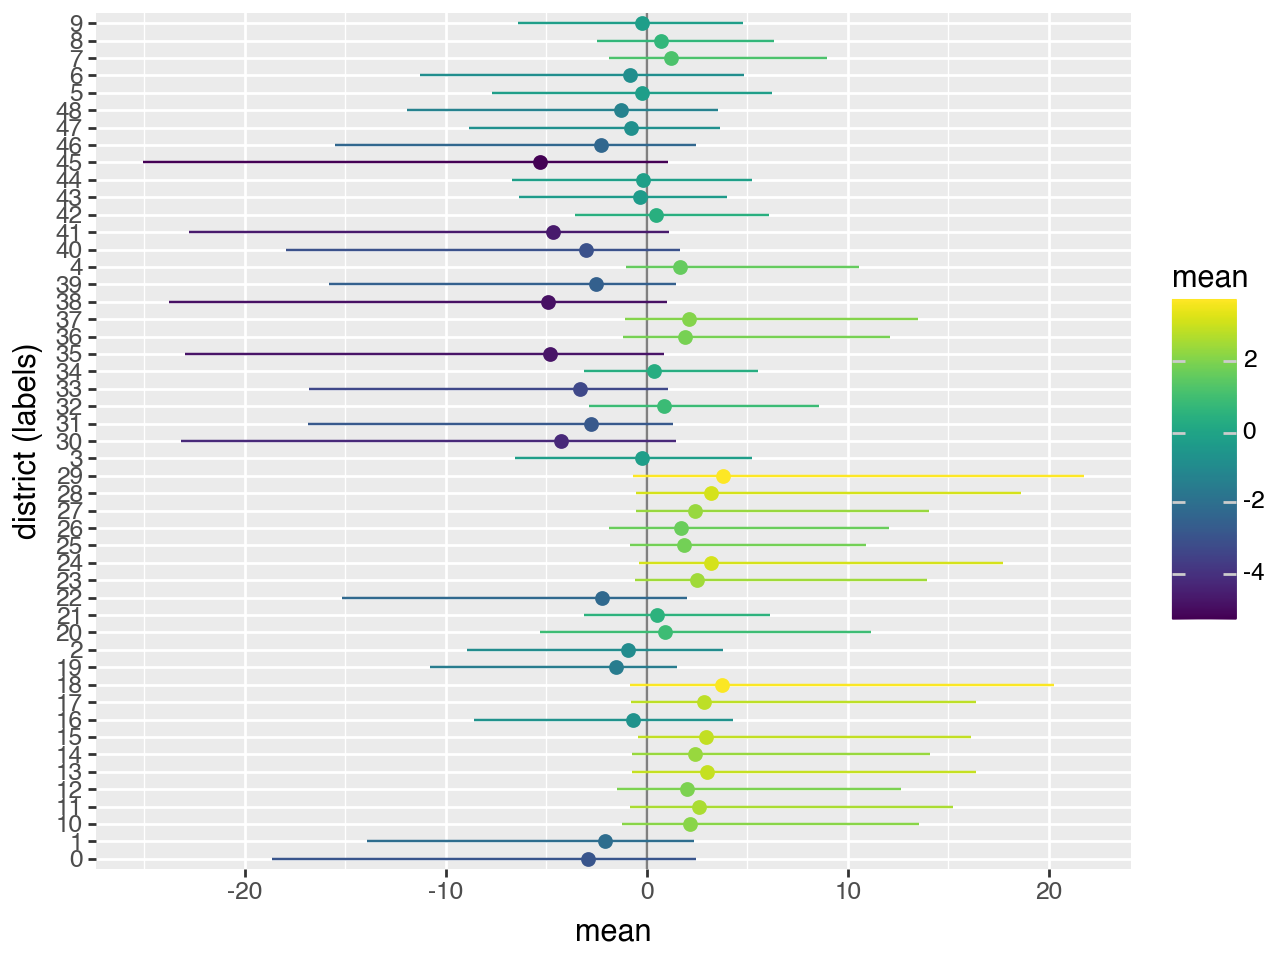

In [ ]:
gam.plot_forest(
    term=loc.terms["mrf1(district)"],
    samples=samples,
    ymin="q_0.05",
    ymax="q_0.95",
    show_unobserved=True,
)